# Interactively locating the swarm

In [7]:
#%matplotlib inline
%matplotlib widget

## imports

In [8]:
import cv2 as cv2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
from ipywidgets import HBox, Textarea, interact

## functions

In [9]:
def l2n(x):
    return np.array(x)
def parseCircles(circles):
    x = []
    y = []
    r = []
    for i in range(len(circles[0])):
        x.append(circles[0][i,0])
        y.append(circles[0][i,1])
        r.append(circles[0][i,2])
        
    x,y,r = l2n(x), l2n(y),l2n(r)
    return x,y,r

def timeToSec(timeStr):#Transform m:s format into total number of seconds
    timeArr = timeStr.split(':')
    timeMin = int(timeArr[0])
    timeSec = int(timeArr[1])
    totSec = timeMin*60+timeSec
    return totSec

In [10]:
def preProcessFrame(frame):
    #blur and grayout a frame
    
    # Convert to grayscale.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      
    # Convert to HSV and extract the saturation channel
    #sat = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)[:,:,0]

    # median filter
    #median = cv2.medianBlur(gray, 3)
    #gray_blurred = median
    # Blur using 3 * 3 kernel.
    blurSize = 10#5
    gray_blurred = cv2.blur(gray, (blurSize, blurSize))
    
    return gray_blurred

def detectCircles(frame,minRadius,maxRadius,param1=30,param2=25,dp=1):
    
    #minDist = minRadius-1
    minDist = int(2.5*maxRadius)
    
    # Apply Hough transform on the blurred image.
    circles = cv2.HoughCircles(frame, 
                cv2.HOUGH_GRADIENT,dp, minDist, param1 = param1,
                param2 = param2, minRadius = minRadius, maxRadius = maxRadius)

    return circles
    
def captureFrame(video,frame_id):
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = video.read()
    if ret:
        return frame
    else:
        return ret

def drawCircles(circles,ax ):
    if circles is not None:  
    # Convert the circle parameters a, b and r to integers.
    #detected_circles = np.uint16(np.around(detected_circles))
    #fig, ax = plt.subplots() 
        for pt in circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]
            circle = plt.Circle((a, b), r, color='r',fill=False)
            ax.add_patch(circle)
            #ax.imshow(frame, cmap = 'gray')
def drawRectangle(xc,yc,wc,hc,ax):
    originx=xc
    originy=yc
    ax.add_patch(Rectangle((originx,originy),wc,hc,fc='none',ec='g',lw=1))
    
def drawCirclesDf(df,ax,color):
    
    
    for index, row in df.iterrows():
        x,y,r = row.x,row.y,row.r
        #circle = plt.Circle((x, y), r, color='r',fill=False)
        circle = plt.Circle((x, y), r, color=color,fill=False)
        ax.add_patch(circle)

def circlesToDataFrame(circles,frameNum):    
    x,y,r = parseCircles(circles)
    data = {'frame':[int(frameNum)]*len(x),'x':x,'y':y,'r':r}
    dft = pd.DataFrame(data = data)
    
    return dft


def cropImage(img,x0,y0,width,height):
    return img[y0:y0+height,x0:x0+width,:]
'''def cropImage(img,x0,y0,width,height):
    d = len(img.shape)
    if d==2: #grayscale
        return img[y0:y0+height,x0:x0+width]
    elif d==3: #rgb
        return img[y0:y0+height,x0:x0+width,:]
'''


'def cropImage(img,x0,y0,width,height):\n    d = len(img.shape)\n    if d==2: #grayscale\n        return img[y0:y0+height,x0:x0+width]\n    elif d==3: #rgb\n        return img[y0:y0+height,x0:x0+width,:]\n'

## Video filenames

In [11]:

arenaSizePixels = 1090 # [pixels]
arenaSizeCm = 150 # [cm]



In [6]:
#load from experiment summary
#REVISED experiments are #13, 14 
#13, D:\Eden\27_12_22\aligners-12cm\C0532.MP4
#14, D:\Eden\27_12_22\aligners-12cm\C0531.MP4
expSum = pd.read_csv('transportExpSum20230309bots21.csv')

#Choose experiment to analyze
videosToLocate = [8,10,11,13,14,16,19]
videosToLocate = [8]
expNum = videosToLocate[0]
#expNum=5

row = expSum.iloc[expNum]
fileNameVideo = row.path
fileNameVideo

radiusMin = row.minCircleRadius
radiusMax = row.maxCircleRadius

FileNotFoundError: [Errno 2] No such file or directory: 'transportExpSum20230309bots21.csv'

## video parameters

In [7]:
# Load video file
video = cv2.VideoCapture(fileNameVideo)
# Load locating file
#df = pd.read_csv(fileNameLocated)

#get videos properties
width  = video.get(cv2.CAP_PROP_FRAME_WIDTH )
height = video.get(cv2.CAP_PROP_FRAME_HEIGHT )
fps = video.get(cv2.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
frameCount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
pixelSize = arenaSizeCm/arenaSizePixels
print(frameCount)

31464


## Locating params

In [8]:
x0,y0 = 310,0
width0,height0 = 1160,1080

#frameNum = 1500
threshMin = 10
threshMax = 50

radiusMin = 6#row.minCircleRadius
radiusMax = 10#row.maxCircleRadius

param1 = 35#30 #100#25#35#30#25#25
param2 = 15#35



#frameRange = df.frame.unique()#range(frameMin,frameMax,frameSkip)
#
#frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)

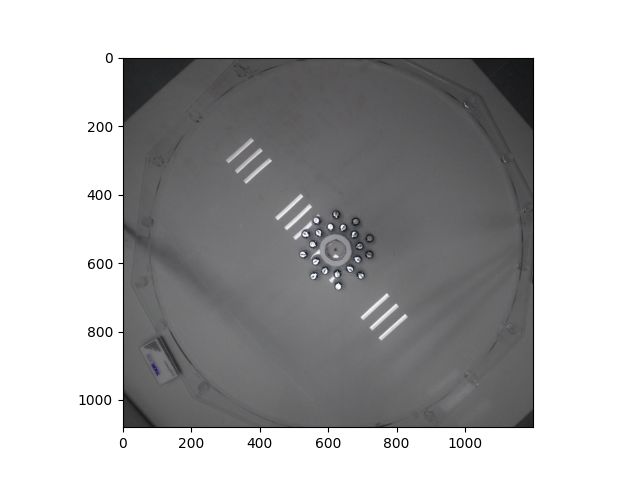

In [9]:
frameMin=0
frameNum = frameMin

frameNum = 1000

'''boxSize = int(2*(2*radiusMax))
boxSize = 300
wc,hc = boxSize,boxSize
#xc,yc = int(958-boxSize/2),int(548-boxSize/2)
xc,yc = boxSize/2,boxSize/2
'''
boxSize = int(2*(2*radiusMax))
wc,hc = boxSize,boxSize
xc,yc = int(958-boxSize/2),int(548-boxSize/2)

fig,ax= plt.subplots()
img = captureFrame(video,frameNum)
#imgRed = img[:,:,0]
#imgCropped = cropImage(imgRed,x0,y0,width0,height0)
#imgCropped = img#cropImage(img,xc,yc,wc,hc)
imgCropped = cropImage(img,300,0,1200,int(height))

imgE = cv2.Canny(imgCropped,threshMin,threshMax)
#imgT = cv2.threshold(imgCropped,20,120)
ax.imshow(imgCropped)
#drawCircles(circles,plt.gca())

In [10]:
print(row.path)

D:\Eden\27_12_22\fronters-12cm\C0537.MP4


In [11]:
plt.ioff()
fig1 = plt.figure()
ax1 = fig1.gca()
#ax.imshow(frame,cmap='Greys')
plt.ion()
#fig1.canvas

## widget cell

In [14]:
#fig,ax = plt.subplots()
blobDiameter = 19
starting_point=0
frame_step=100
frameRange= range(starting_point,frameCount,frame_step)
#@interact(frameNum=frameRange,wc=wc,hc=hc,xc=xc,yc=yc,threshMin=threshMin,)#df.frame.values)    
@interact(frameNum=frameRange,\
          threshMin=(0,500),\
          threshMax=(0,1800),\
          param1=(0,param1*2),\
          param2=(0,param2*2),\
          radiusMin=(0,radiusMin*2),\
          radiusMax=(0,radiusMax*2))
        #  minMass=(0,5000),
        # black_white_thresh=(0,255),\
        # botDiameter = (7,25))
        
#def drawPassiveParticleOnFrame(frameNum,wc,hc,xc,yc,threshMin,threshMax):
def drawPassiveParticleOnFrame(frameNum,threshMin,threshMax,param1,param2,radiusMin,radiusMax):#,minMass,black_white_thresh,botDiameter):
    img = captureFrame(video,frameNum)
    imgCropped = cropImage(img,300,0,1200,int(height)) 
    #Edge detection:
    imgGray = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
    
    #thresh = 127
    #invert the iamge
    #imgInv = imgGray#255-imgGray
    #imgBW = cv2.threshold(imgInv, black_white_thresh, 255, cv2.THRESH_BINARY)[1]
    #imgE = cv2.Canny(imgCropped,threshMin,threshMax)
    #imgE = cv2.Canny(grayImage,threshMin,threshMax)
    circles = detectCircles(imgGray,radiusMin, radiusMax,param1,param2)
    
    #imgBlur = cv2.blur(imgGray,(10,10))
    #dfLoc = tp.locate(imgB, diameter=blobDiameter,minmass=2500,invert=True)
    #if not (botDiameter%2):
    #    botDiameter+=1
    #make sure diameter is odd
    #invert = True
    #dfLoc = tp.locate(imgGray, diameter=botDiameter,minmass=minMass,invert=invert)
    
    #print("circles data")
    #print(circles)
    '''
    if circles is not None:        
        xc = int(xc+circles[0][0][0]-wc/2)
        yc = int(yc+circles[0][0][1]-hc/2)
        #restore box incase it reaches the edge of the frame:
        xc = max(0,xc)
        xc = min(xc,width-wc)               
        xc = int(xc)

        yc = max(0,yc)
        yc = min(yc,height-hc)              
        yc = int(yc)
    '''
    '''
    param1 = 60
    param2 = 16
    radiusMin = 6
    radiusMax = 12
    '''
    
    frame  = captureFrame(video,frameNum)
    img = frame#cropImage(frame,x0,y0,width0,height0)
    ax1.cla()
    #ax1.imshow(imgCropped)
    ax1.imshow(imgGray)
    drawCircles(circles,ax1)
    #drawRectangle(xc,yc,wc,hc,ax1)
    #ax1.plot(dfLoc.x,dfLoc.y,'o',markersize=10,markerfacecolor='none',markeredgecolor='c')
    #ax.imshow(img, cmap='Greys')
HBox([fig1.canvas])

interactive(children=(Dropdown(description='frameNum', options=(0, 100, 200, 300, 400, 500, 600, 700, 800, 900…

## data create cell (might take a while??)
create the data for the statistic cell

In [13]:
print(row.path)

D:\Eden\27_12_22\fronters-12cm\C0537.MP4


In [14]:
#Video handle
video = cv2.VideoCapture(fileNameVideo)

#other paramters of the experiment
startMin = row.start_min
endMin = row.end_min

startSecond = timeToSec(startMin)


In [15]:
param1 = 35#30 #100#25#35#30#25#25
param2 = 15#35
radiusMin = 6#23
radiusMax = 10#33


In [36]:
data = {'frame':[],'x':[],'y':[],'r':[]}
columns = ['frame','x','y','r']
df = pd.DataFrame(data=data,columns=columns)

#start_point=6000
#end_point=8000#frameCount

video.set(cv2.CAP_PROP_POS_FRAMES, frameMin)
ret = True
count=0

while ret:
        #video.grab()#captureFrame(video,frameNum)
    count=count+1
    if count%500==0:
        print(count)
        
    if count>500:
        break;
    ret, img = video.read()
    
    if(ret): #if succesfffuly read an image
        frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
        
        #imgGray = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
        imgCropped = cropImage(img,300,0,1200,int(height))
        grayImage = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
        #Edge detection:
        #imgE = cv2.Canny(imgCropped,threshMin,threshMax)
        circles = detectCircles(grayImage,radiusMin, radiusMax,param1,param2)
            #if circles[0,:,0]
            #circle=circles[0][0]
            #print(circle)
        if circles is not None:#circle        
            dft = circlesToDataFrame(circles,frameNum)
            #dft = circlesToDataFrame(circle,frameNum)
            #Move the located center relative to the moving locating window box
            #dft['x'] = dft['x']+xc
            #dft['y'] = dft['y']+yc

            df = pd.concat([df,dft],ignore_index=True)
print("df test")
print(df)
fileNameLoc = 'temporaryLocatingFileBots.csv'#fileNameVideo+locateFileNameSuffix+'_8.csv'
df.to_csv(fileNameLoc) 

500
df test
       frame      x      y    r
0        1.0  563.5  476.5  8.2
1        1.0  524.5  575.5  8.2
2        1.0  627.5  669.5  8.2
3        1.0  720.5  528.5  8.2
4        1.0  531.5  516.5  8.2
...      ...    ...    ...  ...
10665  500.0  684.5  591.5  8.2
10666  500.0  662.5  619.5  8.2
10667  500.0  587.5  624.5  9.4
10668  500.0  694.5  639.5  7.1
10669  500.0  569.5  512.5  8.2

[10670 rows x 4 columns]


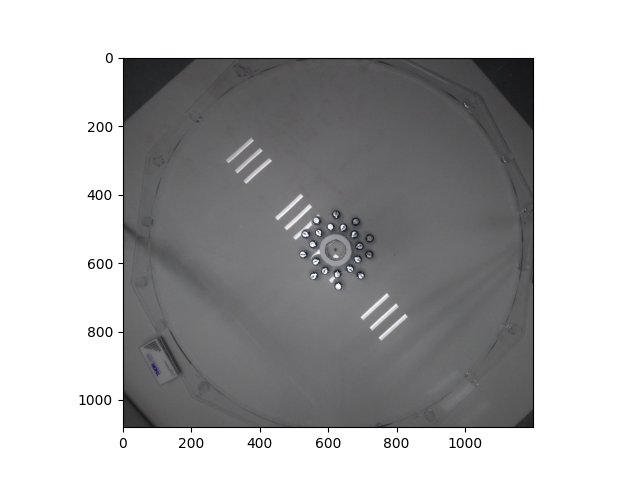

In [37]:
fig4,ax4=plt.subplots()
ax4.imshow(imgCropped)

### test tp.locate

In [38]:
#frameNum=0
#img = captureFrame(video,frameNum)
#imgCropped = cropImage(img,300,0,1200,int(height)) 
#Edge detection:
#imgGray = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
#imgBW = cv2.threshold(imgGray, 65, 255, cv2.THRESH_BINARY)[1]
#f = tp.locate(imgBW, 1001, invert=False)
#f.head()
#tp.annotate(f, imgBW);

In [39]:
'''data = {'frame':[],'x':[],'y':[],'r':[]}
columns = ['frame','x','y','r']
df = pd.DataFrame(data=data,columns=columns)

#start_point=6000
#end_point=8000#frameCount

video.set(cv2.CAP_PROP_POS_FRAMES, frameMin)
ret = True
count=0

while ret:
        #video.grab()#captureFrame(video,frameNum)
    count=count+1
    if count%500==0:
        print(count)
        
    if count>3000:
        break;
    ret, img = video.read()
    
    if(ret): #if succesfffuly read an image
        frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
        
        #imgGray = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
        imgCropped = cropImage(img,300,0,1200,int(height))
        grayImage = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
        f = tp.locate(grayImage, 314, invert=True)
        #Edge detection:
        #imgE = cv2.Canny(imgCropped,threshMin,threshMax)
        #circles = detectCircles(grayImage,radiusMin, radiusMax,param1,param2)
            #if circles[0,:,0]
            #circle=circles[0][0]
            #print(circle)
        #if circles is not None:#circle        
            #dft = circlesToDataFrame(circles,frameNum)
            #dft = circlesToDataFrame(circle,frameNum)
            #Move the located center relative to the moving locating window box
            #dft['x'] = dft['x']+xc
            #dft['y'] = dft['y']+yc

            #df = pd.concat([df,dft],ignore_index=True)
print("df test")
print(df)
fileNameLoc = 'temporaryLocatingFileBots.csv'#fileNameVideo+locateFileNameSuffix+'_8.csv'
df.to_csv(fileNameLoc)''' 

'data = {\'frame\':[],\'x\':[],\'y\':[],\'r\':[]}\ncolumns = [\'frame\',\'x\',\'y\',\'r\']\ndf = pd.DataFrame(data=data,columns=columns)\n\n#start_point=6000\n#end_point=8000#frameCount\n\nvideo.set(cv2.CAP_PROP_POS_FRAMES, frameMin)\nret = True\ncount=0\n\nwhile ret:\n        #video.grab()#captureFrame(video,frameNum)\n    count=count+1\n    if count%500==0:\n        print(count)\n        \n    if count>3000:\n        break;\n    ret, img = video.read()\n    \n    if(ret): #if succesfffuly read an image\n        frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)\n        \n        #imgGray = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)\n        imgCropped = cropImage(img,300,0,1200,int(height))\n        grayImage = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)\n        f = tp.locate(grayImage, 314, invert=True)\n        #Edge detection:\n        #imgE = cv2.Canny(imgCropped,threshMin,threshMax)\n        #circles = detectCircles(grayImage,radiusMin, radiusMax,param1,param2)\n            #if 

## linking

In [42]:
tp.quiet()
search_range= 80
memory= 100
minTrajLength =500//4 #This is not the best condition (Matan)
t = tp.link(df, search_range=search_range, memory=memory)
t1=tp.filter_stubs(t,threshold=minTrajLength)
path='temporaryLinkingFileBots.csv'
t1.to_csv(path)

In [43]:
t1 = tp.filter_stubs(t,threshold=500)

In [44]:
len(t1.particle.unique())

20

### Locating params

In [ ]:
plt.ioff()
fig1 = plt.figure()
ax1 = fig1.gca()
#ax.imshow(frame,cmap='Greys')
plt.ion()
#fig1.canvas

In [ ]:
########################################widget_cell#####################################################################################
#fig,ax = plt.subplots()
starting_point=1
frame_step=50
maxFrame = frameCount#20000#frameCount
trailLength = 300

frameRange= range(starting_point,maxFrame,frame_step)
@interact(frameNum=frameRange)#df.frame.values)
def drawPassiveParticleOnFrame(frameNum):
    
    dff =df[df.frame==frameNum]
    
    x,y,r = dff.x.values,dff.y.values,dff.r.values
    
    circles = [[x,y,r]]
    img  = captureFrame(video,frameNum)
    imgCropped =cropImage(img,300,0,1200,int(height))
    
    ax1.cla()
    ax1.imshow(imgCropped)
    drawCirclesDf(dff,ax1)
    cond = (frameNum-trailLength<t.frame) &(t.frame<frameNum)
    tC = t[cond]
    if len(tC)==0 :
        tC = t[t.frame==frameNum]
        
    cond = df.frame==frameNum
    dfC = df[cond]
    tp.plot_traj(tC,ax=ax1,label=True)
    drawCirclesDf(dfC,ax1)
    #ax.imshow(img, cmap='Greys')
    
HBox([fig1.canvas])

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

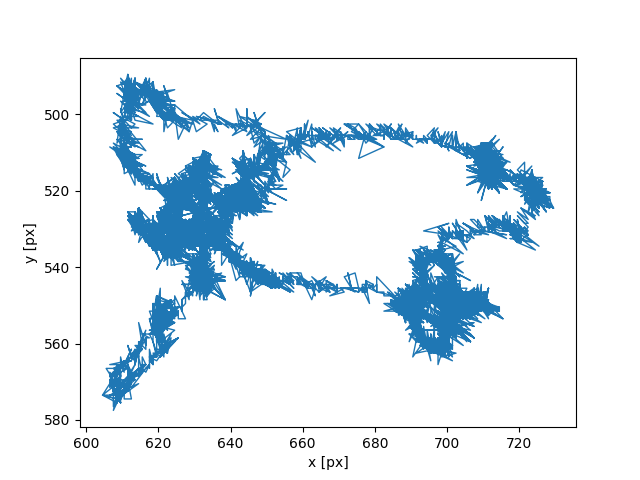

In [242]:
fig3,ax3 = plt.subplots()
tp.plot_traj(t1,ax=ax3)

In [126]:
expSum20230309 = pd.read_csv('transportExpSum20230309bots21_.csv',index_col=0)

In [136]:
videosToLocate = [10,11,13,14,16]

In [145]:
row = expSum20230309.iloc[16]
fileName =  row.locatingFileName

df = pd.read_csv(fileName)
print(fileName)

D:\Eden\22_12_22_blend\alingners-12cm\C0529.MP4_locatedFull20230308_matan.csv


In [147]:
len(df)

502

In [130]:


tp.quiet()
search_range= 80
memory= 1000
minTrajLength =int(frameCount/4)
t = tp.link(df, search_range=search_range, memory=memory)
t1=tp.filter_stubs(t,threshold=minTrajLength)
print(t1)

Empty DataFrame
Columns: [Unnamed: 0, frame, x, y, r, particle]
Index: []


In [94]:
len(t1.particle.unique())

1

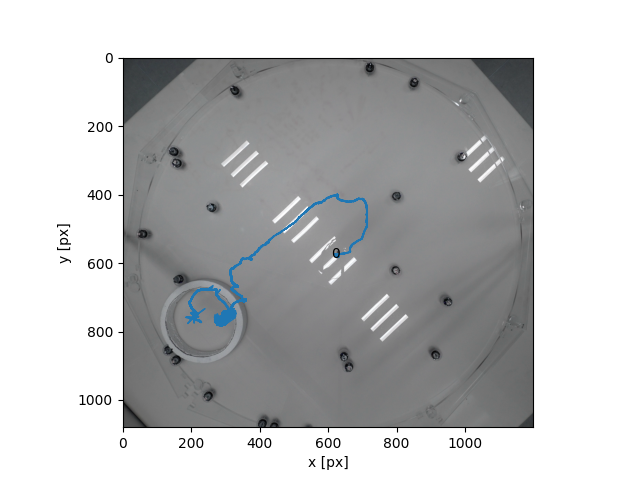

In [95]:
fig3,ax3 = plt.subplots()#poiuytra
ax3.imshow(imgCropped)

t2=t1.copy()#tp.filter_stubs(t,10)#t.copy()
x,y = df.x,df.y
#ax3.plot(x,y,'o')
tp.plot_traj(t2,ax=ax3,label='particle')
ax.invert_yaxis()

#ax3.set(xlim=(0, 1189), ylim=(0, 1072))

In [96]:
imsd.columns

Int64Index([0], dtype='int64')

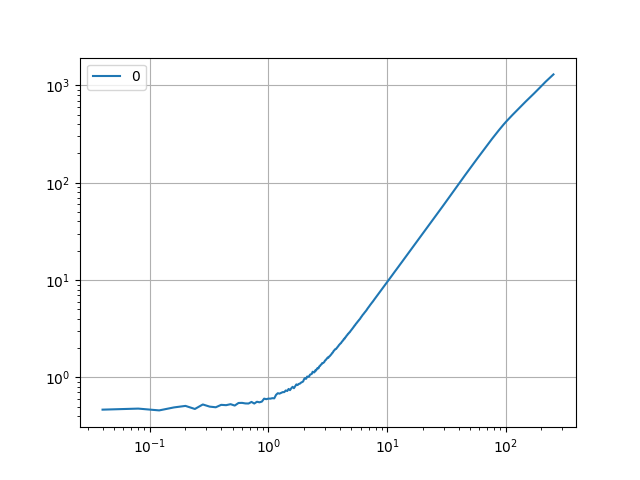

In [98]:
fig4,ax4 = plt.subplots()
imsd = tp.imsd(t1,pixelSize,fps,max_lagtime=int(frameNum/3))


ax4.loglog(imsd)
ax4.legend(imsd.columns)
ax4.grid()

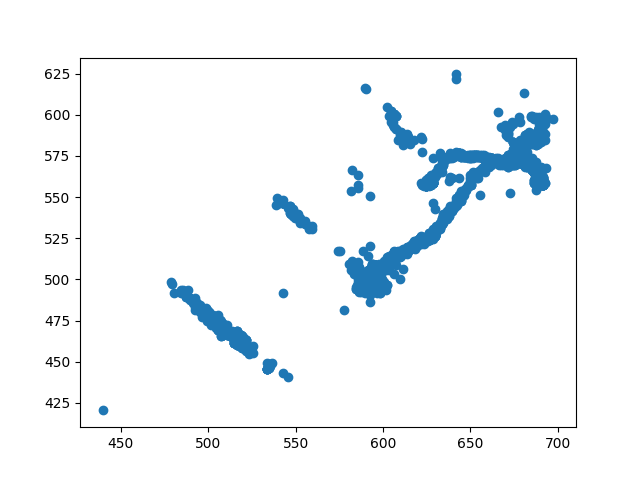

In [284]:
fig5,ax5 = plt.subplots()

particleNum = 0

cond = t1.particle==particleNum
t1f = t1[cond]

ax5.plot(t1f.x,t1f.y,'o')

In [157]:
#fig,ax = plt.subplots()

starting_point=0
frame_step=1
frameRange= range(starting_point,frameCount,columns_step)
@interact(frameNum=frameRange,wc=wc,hc=hc,xc=xc,yc=yc)#df.frame.values)    
def drawPassiveParticleOnFrame(frameNum,wc,hc,xc,yc):

    tt1=t1[t1.frame==frameNum]
    
    x,y,r = tt1.x.values,tt1.y.values,tt1.r.values
    
    circles = [[x,y,r]]
    frame  = captureFrame(video,frameNum)
    img = frame#cropImage(frame,x0,y0,width0,height0)
    ax1.cla()
    ax1.imshow(imgCropped)
    drawCircles(tt1,ax1)
    
    #ax.imshow(img, cmap='Greys')
HBox([fig1.canvas])

interactive(children=(Dropdown(description='frameNum', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

## statistic cell

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


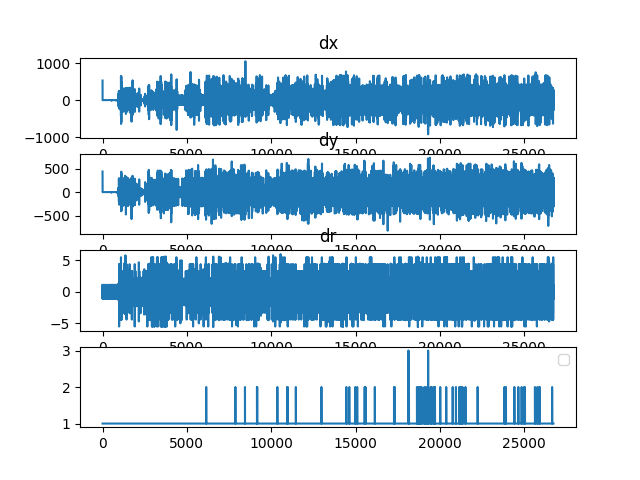

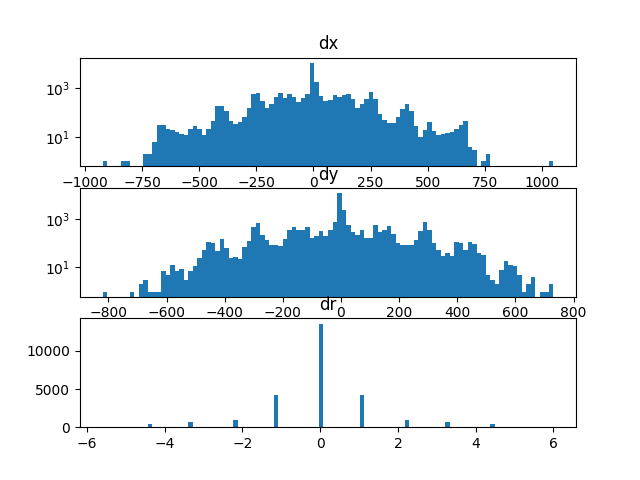

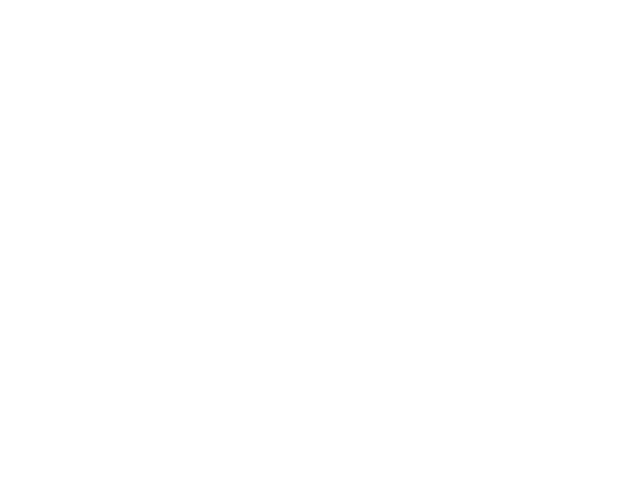

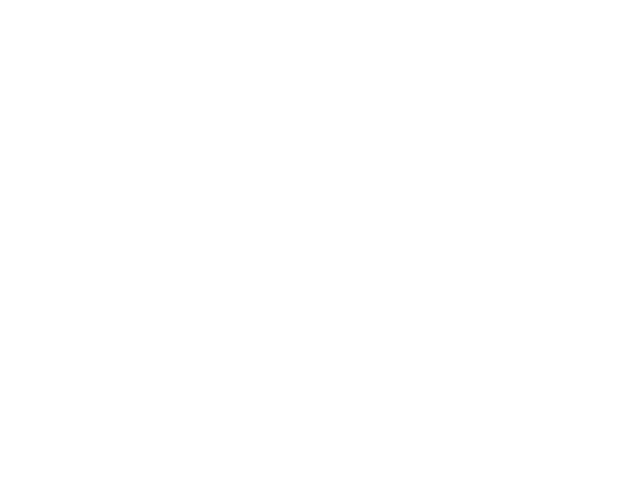

In [143]:
#######################figures stataistic of dx dy dr-same as interactiveLocateTest################################
#period = 1
dx,dy,dr,dif_frame=df.x.diff(),df.y.diff(),df.r.diff(),df.frame.diff()
#frame=df.loc[:,"frame"]
plt.figure()
fig1, axis = plt.subplots(4,1)
axis[0].plot(dx)
axis[0].set_title("dx")
axis[1].plot(dy)
axis[1].set_title("dy")
axis[2].plot(dr)
axis[2].set_title("dr")
axis[3].plot(dif_frame)

plt.legend()
plt.show()


n_bins = 100
plt.figure()
fig2, axs = plt.subplots(3,1)
axs[0].hist(dx,bins=n_bins)
axs[0].set_title("dx")
axs[0].set_yscale('log')
axs[1].hist(dy,bins=n_bins)
axs[1].set_title("dy")
axs[1].set_yscale('log')
axs[2].hist(dr,bins=n_bins)
axs[2].set_title("dr")
plt.show()

## interpulation cell

In [17]:
#starting_point=start_point
#frame_step=1
#frameRange= range(0,frameCount,frame_step)
frame=df.loc[:,"frame"]
x=df.loc[:,"x"]
y=df.loc[:,"y"]
r=df.loc[:,"r"]
print(len(frame))
print(len(x))
print(len(y))
print(len(r))
new_frame=np.linspace(0,frameCount,num=frameCount)
new_x=np.interp(new_frame,frame,x)
new_y=np.interp(new_frame,frame,y)
new_r=np.interp(new_frame,frame,r)


2606
2606
2606
2606


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


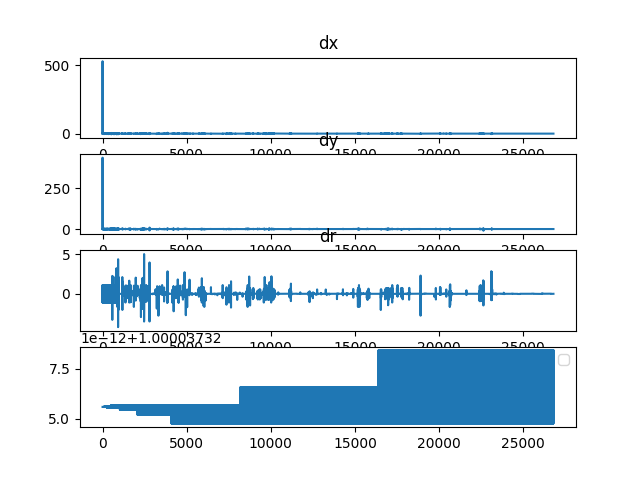

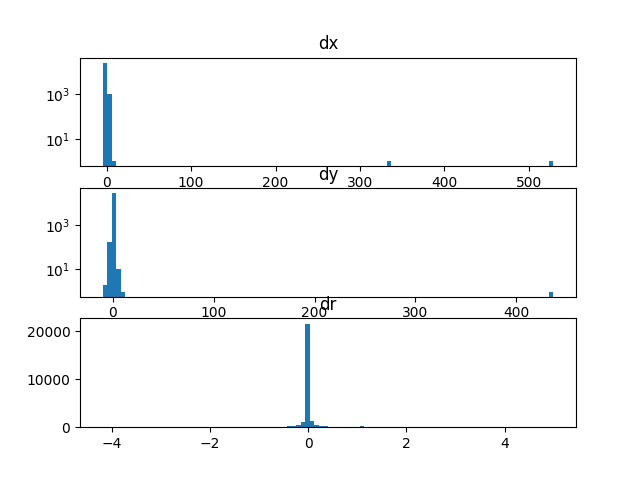

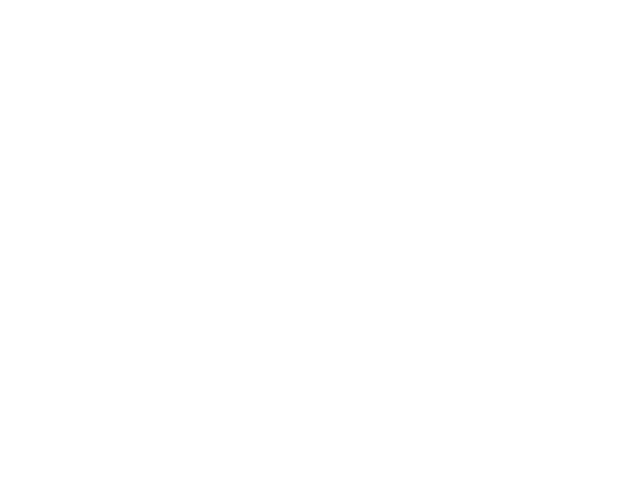

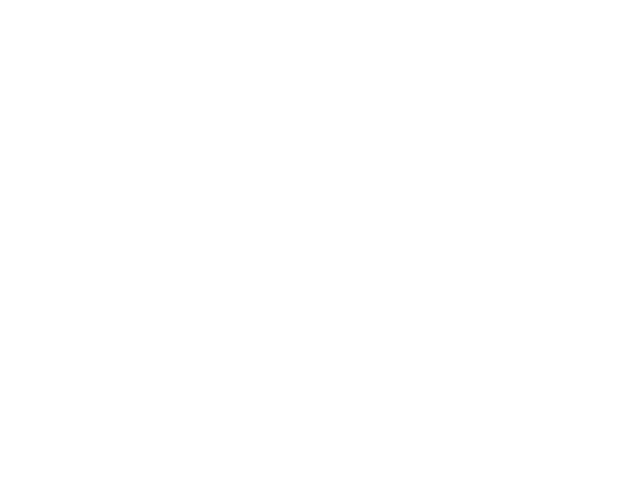

In [18]:
#######################figures stataistic of dx dy dr-same as interactiveLocateTest################################
#period = 1
dx,dy,dr,dif_frame=np.diff(new_x),np.diff(new_y),np.diff(new_r),np.diff(new_frame)
#frame=df.loc[:,"frame"]
plt.figure()
fig1, axis = plt.subplots(4,1)
axis[0].plot(dx)
axis[0].set_title("dx")
axis[1].plot(dy)
axis[1].set_title("dy")
axis[2].plot(dr)
axis[2].set_title("dr")
axis[3].plot(dif_frame)

plt.legend()
plt.show()


n_bins = 100
plt.figure()
fig2, axs = plt.subplots(3,1)
axs[0].hist(dx,bins=n_bins)
axs[0].set_title("dx")
axs[0].set_yscale('log')
axs[1].hist(dy,bins=n_bins)
axs[1].set_title("dy")
axs[1].set_yscale('log')
axs[2].hist(dr,bins=n_bins)
axs[2].set_title("dr")
plt.show()